# European Option Pricing: Black-Scholes vs. Monte Carlo Simulation

Objective: This notebook develops and compares two fundamental methods for pricing a European call option:
1. The Analytical Black-Scholes-Merton (BSM) Model: A closed-form solution that provides an exact price under a set of idealised assumptions.
2. The Numerical Monte Carlo (MC) Simulation Method: A flexible, simulation-based approach that can be extended to a more complex "exotic" options.
The objective is to implement both methods, validate the Monte Carlo pricer against the BSM benchmark, and analyse its convergence properties. This project demonstrates a core competency in derivatives pricing.

# 1. Theoretical Framework

# 1.1 Risk-Neutral Valuation

The cornerstone of modern option pricing is the principle of risk-neutral valuation. It states that the fair price of a derivative is the expected value of its future payoff, discounted back to today, calculated under a special "risk-neutral" probability measure. In this risk-neutral world, all assets are assumed to grow, on average, at the risk-free interest rate, r.
This is why, for pricing purposes, the drift μ in our Geometric Brownian Motion simulation is replaced by r.

# 1.2 Black-Scholes-Merton (BSM) Formula

The BSM model provides an exact formula for the price of a European call option (C) under the assumption that the underlying asset follows BSM:
$$ C(S_0, K, T, r, \sigma) = S_0 N(d_1) - K e^{-rT} N(d_2) $$
Where:
- S_0: Current stock price
- K: Option strike price
- T: Time to maturity (in years)
- r: Risk-free interest rate
- σ: Volatility of the stock
- N(⋅): The cumulative distribution function (CDF) of the standard normal distribution.
And d_1 and d_2 are given by:
$$ d_1 = \frac{\ln(S_0/K) + (r + \frac{\sigma^2}{2})T}{\sigma\sqrt{T}} $$
$$ d_2 = d_1 - \sigma\sqrt{T} $$

# 1.3 The Monte Carlo Method

The Monte Carlo approach leverages the risk-neutral valuation principle directly and consists of three steps:
1. Simulate: Generate a large number (M) of possible future asset price paths (S_T) under the risk-neutral GBM dynamics (dS_t = rS_tdt + σS_tdW_t).
2. Calculate Payoff: For each simulated final price S_T, i, calculate the option's payoff. For a call option, this is Payoff*i = max(S*T,i-K,0).
3. Discount & Average: Calculate the average of all these payoffs and discount it back to the present value using the risk-free rate.
$$ C_0 \approx e^{-rT} \times \frac{1}{M} \sum_{i=1}^{M} \max(S_{T,i} - K, 0) $$
By the Law of Large Numbers, as the number of simulation M tends towards infinity, the Monte Carlo price will converge to the true BSM price.

# 2. Implementation

First, we import the necessary libraries and reuse our GBM simulator from the previous notebook.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Set a professional plot style
plt.style.use('seaborn-v0_8-whitegrid')

def simulate_gbm_risk_neutral(S0, r, sigma, T, N, num_paths):
    """
    Simulates multiple paths of Geometric Brownian Motion under the risk-neutral measure.
    """
    dt = T / N
    Z = np.random.standard_normal(size=(N, num_paths))
    S = np.zeros((N + 1, num_paths))
    S[0] = S0
    
    for t in range(1, N + 1):
        # Using the risk-neutral drift 'r' instead of 'mu'
        S[t] = S[t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[t-1])
        
    return S

Note: We have switched to the log-normal form of the GBM discretisation: 
lnST=lnS0+(r−σ22)T+σWT∼N(lnS0+(r−σ22)T,σT). This is a more precise and stable formulation than the arithmetic one used previously.

# 2.1 Black-Scholes (Analytical) Pricer

In [3]:
def black_scholes_call(S0, K, T, r, sigma):
    """
    Calculates the price of a European call option using the Black-Scholes formula.
    """
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    call_price = (S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
    return call_price

# 2.2 Monte Carlo (Numerical) Pricer

In [4]:
def monte_carlo_call_pricer(S0, K, T, r, sigma, num_paths):
    """
    Calculates the price of a European call option using Monte Carlo simulation.
    """
    N = 252 # Daily steps for a 1-year option
    
    # Simulate the stock price paths
    # We only need the final price, so we can optimize by only simulating the endpoint
    Z = np.random.standard_normal(num_paths)
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    
    # Calculate the payoff for each path
    payoffs = np.maximum(ST - K, 0)
    
    # Discount the average payoff
    call_price = np.exp(-r * T) * np.mean(payoffs)
    
    return call_price

# 3. Validation and Convergence Analysis

Now, we define our market parameters and compare the results. The key test is to see how the Monte Carlo price converges to the analytical Black-Scholes price as we increase the number of simulation paths.

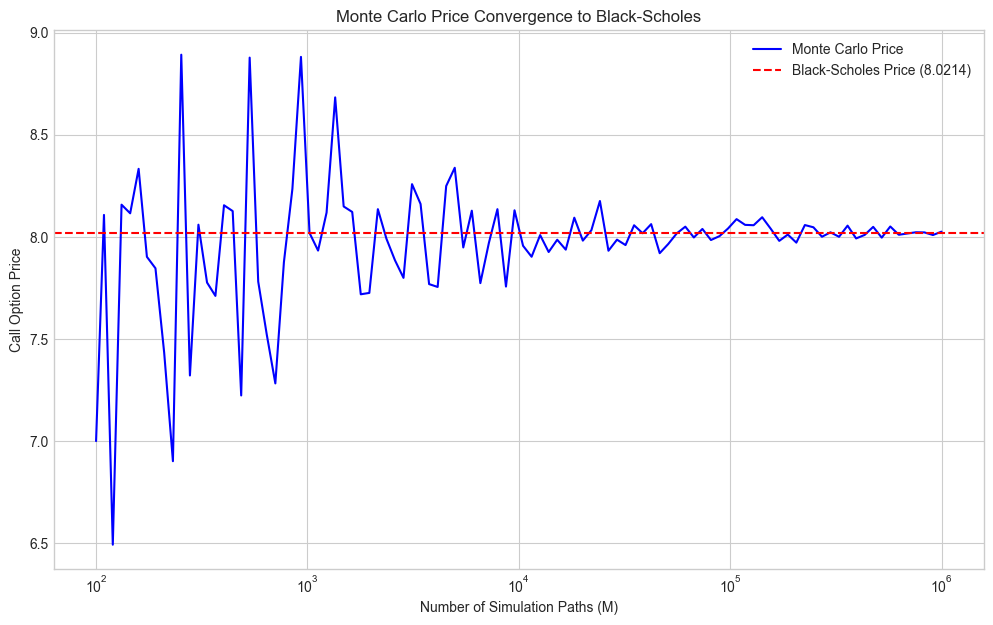

Analytical Black-Scholes Price: 8.0214
Monte Carlo Price (1M paths): 8.0255


In [5]:
# --- Option & Market Parameters ---
S0 = 100         # Initial stock price
K = 105          # Strike price
T = 1.0          # Time to maturity (1 year)
r = 0.05         # Risk-free rate (5%)
sigma = 0.20     # Annual volatility (20%)

# --- Calculate Analytical Price ---
bsm_price = black_scholes_call(S0, K, T, r, sigma)

# --- Run Monte Carlo Convergence Test ---
path_counts = np.logspace(2, 6, 100, dtype=int) # From 100 to 1,000,000 paths
mc_prices = [monte_carlo_call_pricer(S0, K, T, r, sigma, M) for M in path_counts]

# --- Plot the Results ---
plt.figure(figsize=(12, 7))
plt.plot(path_counts, mc_prices, 'b', label='Monte Carlo Price')
plt.axhline(bsm_price, color='r', linestyle='--', label=f'Black-Scholes Price ({bsm_price:.4f})')
plt.title('Monte Carlo Price Convergence to Black-Scholes')
plt.xlabel('Number of Simulation Paths (M)')
plt.ylabel('Call Option Price')
plt.xscale('log') # Use a log scale for the x-axis for better visualization
plt.legend()
plt.grid(True)
plt.show()

print(f"Analytical Black-Scholes Price: {bsm_price:.4f}")
print(f"Monte Carlo Price (1M paths): {mc_prices[-1]:.4f}")

# 4. Conclusion

The results are conclusive. The plot clearly demonstrates that as the number of simulated paths (M) increases, the Monte Carlo price converges towards the analytical Black-Scholes price. The Law of Large Numbers is visually confirmed. With one million paths, our numerical estimate is extremely close to the true theoretical value.

Key Takeaways:
- Validation: We have successfully built a working Monte Carlo pricing engine and validated its accuracy against a known analytical solution. This is a critical step in any quantitative model development lifecycle.
- Trade-offs: The Black-Scholes model is instantaneous but rigid in its assumptions. The Monte Carlo engine is computationally int